#### <center>WITH AS <center>

AS is used for aliasing. It is used to rename a specific selected table. AS become more powerful when it combined with **WITH**. It is used to make temporary table and called **common table expression** (CTE).

CTEs are useful for splitting queries into readable chunks to make it readable and easy to understand. The temporary table created using WITH then can be refer to. 

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset. We'll investigate the transactions table.

In [1]:
from google.cloud import bigquery

# create client objectt
client = bigquery.Client('intsql-2025')

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project='bigquery-public-data')

# API req, fetching the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API req to fetch table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

/Users/oktavianu/miniforge3/envs/data-analysis/lib/python3.11/site-packages/google/cloud/bigquery/__init__.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution
/Users/oktavianu/miniforge3/envs/data-analysis/lib/python3.11/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/var/folders/7m/y8yqb

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


Since the `block_timestamp` column contains the date of each transaction in `DATETIME` format, I'll convert these into `DATE` format using the `DATE()` command.

I do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [2]:
#  Query to select the number of transactions per date, sorted by date
query_with_cte = """
                 WITH time AS
                 (
                    SELECT DATE(block_timestamp) AS trans_date
                    FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions, 
                     trans_date
                 FROM time 
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# my quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=100 * 10**10)
query_job = client.query(query_with_cte, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transaction_by_date = query_job.to_dataframe()

# Print the first five rows
transaction_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


I can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

<Axes: xlabel='trans_date'>

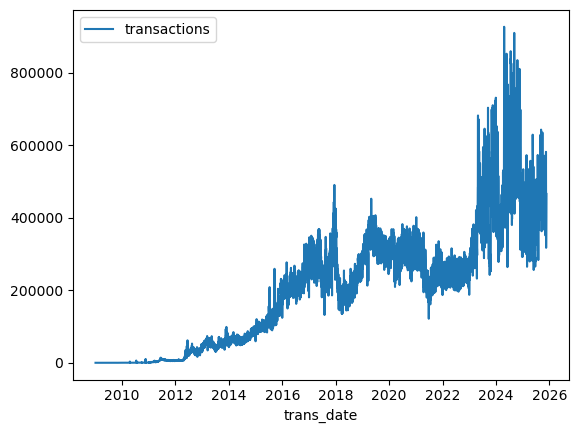

In [3]:
transaction_by_date.set_index('trans_date').plot()

As we can see, common table expressions (CTEs) let us shift a lot of our data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

In [4]:
dataset_ref = client.dataset("chicago_taxi_trips", project='bigquery-public-data')


# Api req to fecth data
dataset = client.get_dataset(dataset_ref)

I am curious  how much slower traffic moves when traffic volume is high. This involves a few steps.

#### 1) Find the data
Before you can access the data, you need to find the table name with the data.

Hint: Tab completion is helpful whenever you can't remember a command. Type client. and then hit the tab key. Don't forget the period before hitting tab.

In [5]:
tables = list(client.list_tables(dataset))

for table in tables:
    print(table.table_id)

taxi_trips


In [6]:
# print column name
for field in table.schema:
    print(f"{field.name:25} | {field.field_type:10} | {field.description}")

AttributeError: 'TableListItem' object has no attribute 'schema'

In [ ]:
table_ref = dataset_ref.table('taxi_trips')
table = client.get_table(table_ref)
client.list_rows(table, max_results=5).to_dataframe()

/var/folders/7m/y8yqbwcj4_s9pbq64p2cdkw00000gn/T/ipykernel_2884/1248719483.py:3: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  client.list_rows(table, max_results=5).to_dataframe()


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,b1142c1c2c66367edf9a8909815a171955954fb1,a945379688097db2f2e6117c99b1431b6eba73c4bcfea8...,2013-08-11 11:15:00+00:00,2013-08-11 11:30:00+00:00,960,0.43,NaN,NaN,7.0,3.0,...,NaN,NaN,Cash,None,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,1117a97ec6e4fc4444af5e4df4123859a84590bc,332d91df72ca990499bcd315dda5decb444abfd0cb3875...,2013-09-17 09:00:00+00:00,2013-09-17 09:00:00+00:00,180,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
2,ca1131c8e2ba0ed7a2a606b416050a55cd411654,332d91df72ca990499bcd315dda5decb444abfd0cb3875...,2013-09-17 09:00:00+00:00,2013-09-17 09:00:00+00:00,60,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
3,6ddcb0bf4a7038e12733b9871146500614ec173e,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-07-21 15:45:00+00:00,2013-07-21 15:45:00+00:00,0,0.01,1.703184e+10,1.703184e+10,33.0,33.0,...,NaN,NaN,Cash,None,41.849247,-87.624135,POINT (-87.6241352979 41.84924675450001),41.849247,-87.624135,POINT (-87.6241352979 41.84924675450001)
4,205fd6cc38c44cf34a6c85f4f5d437e4e5579007,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-07-26 20:00:00+00:00,2013-07-26 20:00:00+00:00,60,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None


#### 3) Determine when this data is from
If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. In order to achieve that, I will Write a query that counts the number of trips in each year.

In [ ]:
rides_per_year_query = """ 
                        WITH taxi AS
                        (
                            SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year
                            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        )
                        SELECT year, COUNT(1) AS num_trips
                        FROM taxi
                        GROUP BY year
                        ORDER BY year
                       """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_year_query_job = client.query(rides_per_year_query, job_config=safe_config)

rides_per_year_result = rides_per_year_query_job.to_dataframe()

print(rides_per_year_result.head())

   year  num_trips
0  2013   27217300
1  2014   37395079
2  2015   32385527
3  2016   31756403
4  2017   24979611


#### 4) Dive slightly deeper
You'd like to take a closer look at rides from 2016. Copy the query you used above in rides_per_year_query into the cell below for rides_per_month_query. Then modify it in two ways:

Use a WHERE clause to limit the query to data from 2016.
Modify the query to extract the month rather than the year.

In [7]:
rides_per_month_query = """ 
                        WITH taxi AS 
                        (
                            SELECT 
                                EXTRACT(YEAR FROM trip_start_timestamp) AS year,
                                EXTRACT(MONTH FROM trip_start_timestamp) AS month
                            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        )
                        SELECT 
                            month, 
                            COUNT(1) AS num_trips
                        FROM taxi
                        WHERE year=2016
                        GROUP BY month
                        ORDER BY month
                        """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_month_query_job = client.query(rides_per_month_query, job_config=safe_config)
rides_per_month_result = rides_per_month_query_job.to_dataframe()
print(rides_per_month_result)

    month  num_trips
0       1    2510389
1       2    2568433
2       3    2851106
3       4    2854290
4       5    2859147
5       6    2841872
6       7    2682912
7       8    2629482
8       9    2532650
9      10    2725340
10     11    2387790
11     12    2312992


Now I will write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

The results will have three columns:

- `hour_of_day` - sort by this column, which holds the result of extracting the hour from trip_start_timestamp.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day. Average speed in miles per hour is calculated as 3600 * SUM(trip_miles) / SUM(trip_seconds). (The value 3600 is used to convert from seconds to hours.)

Query criteria:
- a trip_start_timestamp > 2016-01-01 and < 2016-04-01
- trip_seconds > 0 and trip_miles > 0

I will use a common table expression (CTE) to select just the relevant rides. Because this dataset is very big, this CTE should select only the columns I'll need to create the final output.

In [ ]:
speeds_query = """ 
                WITH RelevantRides AS 
                (
                    SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day,
                            trip_miles,
                            trip_seconds
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    WHERE 
                )

"""



safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
speeds_query_job = client.query(speeds_query, job_config=safe_config)
speeds_query_result = speeds_query_job.to_dataframe()
print(speeds_query_result.head())

NameError: name 'speeds_query' is not defined